In [1]:
%matplotlib inline
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.time import Time
import astropy.units as u
from astropy.units import cds
from lightkurve import LightCurve

from gadfly import PowerSpectrum, SolarOscillatorKernel, Hyperparameters

In [2]:
paths_pkl = ['ps.pkl', 'binned_ps.pkl', 'cutout.pkl']

if not os.path.exists(paths_pkl[0]):
    hdu = fits.open('../data/VIRGO_1min_0083-7404.fits.gz')
    raw_fluxes = hdu[0].data
    header = hdu[0].header
    
    soho_mission_day = Time("1995-12-1 00:00")

    times = (
        soho_mission_day.jd + 
        header['TIME'] + 
        np.arange(header['NAXIS1']) / 1440
    )
    times_astropy = Time(times, format='jd')

    fluxes = raw_fluxes.copy()
    interp_fluxes = np.interp(
        times[raw_fluxes == -99], times[raw_fluxes != -99], fluxes[raw_fluxes != -99]
    )
    d = (times[1] - times[0]) * u.day

    fluxes[raw_fluxes == -99] = interp_fluxes

    fluxes = 1e6 * (fluxes / np.median(fluxes) - 1) * u.cds.ppm

    light_curve = LightCurve(time=times_astropy, flux=fluxes)
    ps = PowerSpectrum.from_light_curve(light_curve, detrend=False)
    binning_500 = ps.cutout(frequency_max=4500*u.uHz).bin(100)
    cutout = ps.cutout(1800*u.uHz, 4500*u.uHz).bin(5_000, log=False)
    
    for path, ps_to_save in zip(paths_pkl, [ps, binning_500, cutout]):
        with open(path, 'wb') as out: 
            pickle.dump(ps_to_save, out)
else: 
    with open(paths_pkl[0], 'rb') as out: 
        ps = pickle.load(out)
    with open(paths_pkl[1], 'rb') as out: 
        binning_500 = pickle.load(out)
    with open(paths_pkl[2], 'rb') as out: 
        cutout = pickle.load(out)

In [3]:
kernel_freq_grid = np.sort(np.concatenate([
    # np.logspace(np.log10(0.05), np.log10(5000), 500),
    np.linspace(1800, 4500, 10_000)
])) * u.uHz

In [4]:
from gadfly import StellarOscillatorKernel, Hyperparameters

hp = Hyperparameters.for_star(
    1*u.M_sun, 1*u.R_sun, 5777*u.K, 1*u.L_sun, 
    bandpass='SOHO VIRGO'
)
kernel = StellarOscillatorKernel(hp)

In [5]:
kernel_ps = PowerSpectrum(
    kernel_freq_grid, kernel.get_psd(2 * np.pi * kernel_freq_grid.value) * u.cds.ppm**2/u.uHz
).bin(5_000, log=False)

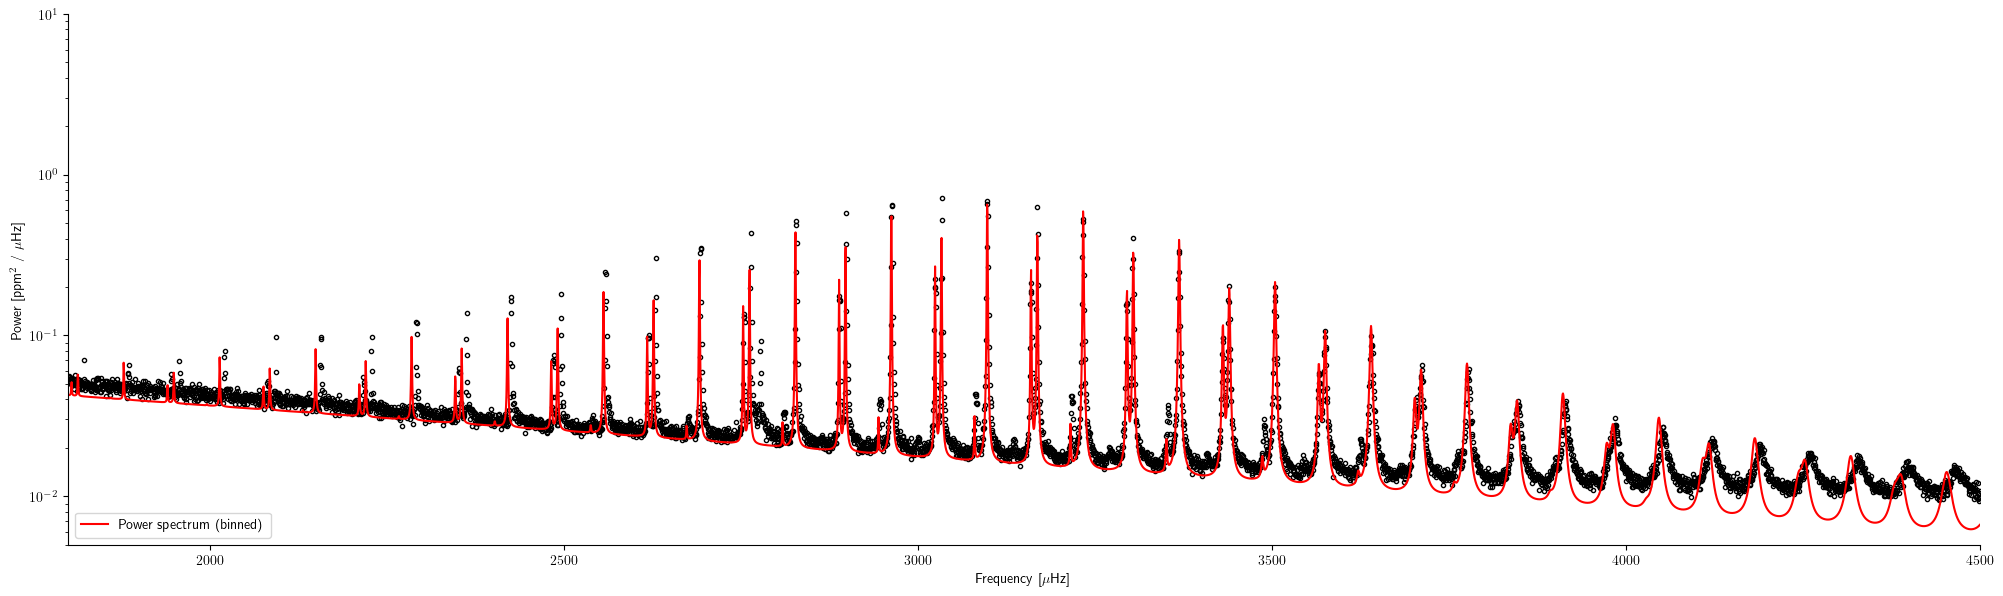

In [6]:
plt.rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(20, 6))
# fig, ax = binning_500.plot(
#     freq=kernel_freq_grid,
#     obs_kwargs=dict(marker='.', color='k'), 
#     figsize=(8, 6), 
#     label_obs='SOHO VIRGO/PMO6',
#     create_new_figure=True,
# )

kernel_ps.plot(
    ax=ax,
    obs_kwargs=dict(marker='', color='r', alpha=1, lw=1.5, zorder=-10, rasterized=True)
)

cutout.plot(
    ax=ax,
    freq=kernel_freq_grid,
    # kernel=kernel,
    p_mode_inset=False,
    inset_bounds=[0.4, 0.6, 0.55, 0.35],
    obs_kwargs=dict(marker='.', color='k', zorder=-100), 
    label_obs='',
    label_kernel='gadfly',
    # kernel_kwargs=dict(color='r', alpha=1, lw=1.5, zorder=-10, rasterized=True),
    # inset_kwargs=dict(marker='.', mfc='none', color='k', zorder=10, rasterized=True, alpha=0.3),
)

# ax.plot(
#     ps.frequency, ps.power, 
#     lw=0.5, alpha=0.1, color='darkslategray', 
#     zorder=-10, rasterized=True
# )
# ax.set(
#     xlim=[0.04, 1e4],
#     ylim=[5e-3, 2e6],
#     yticks=10.0 ** np.arange(-2, 7)
# )

ax.set(
    xlim=[1800, 4500],
    ylim=[5e-3, 1e1],
    xscale='linear'
    # yticks=10.0 ** np.arange(-2, 7)
)
ax.legend(loc='lower left')

for sp in ['right', 'top']:
    ax.spines[sp].set_visible(False)
plt.show()
# fig.savefig('plots/soho_virgo.pdf', bbox_inches='tight', dpi=250)

In [7]:
# n = 22
# dnu = 135
# ell = 0
# eps = 1.48

# dnu * (n + ell/2 + eps) - dnu * (n + ell/2 + (eps - 0.6))

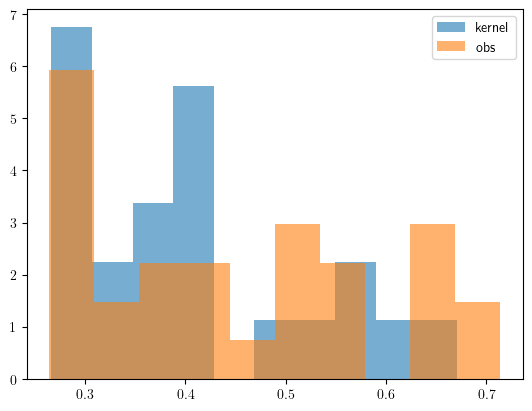

median ratio: 0.5212483189537365


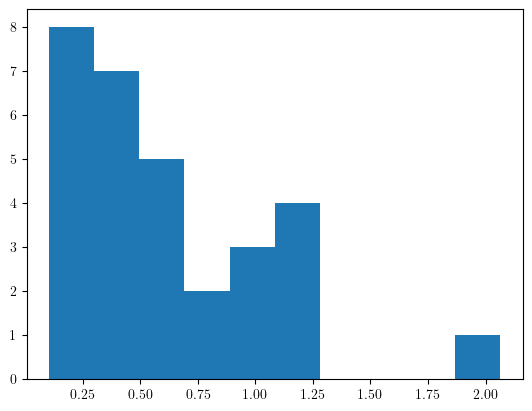

In [8]:

# power_range = (cutout.frequency < 3250 * u.uHz) & (cutout.frequency > 3000 * u.uHz)
power_range = (cutout.frequency < 3500 * u.uHz) & (cutout.frequency > 2800 * u.uHz)
x = cutout.frequency[power_range].value
y_range = (cutout.power[power_range].value > 0.25)

# fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# ax[0].plot(x, cutout.power[power_range])
# ax[0].plot(x, kernel.get_psd(2 * np.pi * x), ls='--')
# ax[1].plot(x[y_range], kernel.get_psd(2 * np.pi * x[y_range]) / cutout.power[power_range][y_range], '.')
# plt.plot(x, , ls='--')# / np.sqrt(np.pi / 2))

peaks_kernel = kernel.get_psd(2 * np.pi * x)
peaks_kernel = peaks_kernel[peaks_kernel > 0.25]

peaks_psd = cutout.power[power_range][y_range].value

transform_peaks_kernel = peaks_kernel # (peaks_kernel - peaks_kernel.min()) / 2 /np.pi + peaks_kernel.min()

plt.hist(transform_peaks_kernel, label='kernel', density=True, alpha=0.6)
plt.hist(peaks_psd, label='obs', density=True, alpha=0.6)
plt.legend()
plt.show()

stat = np.median(kernel.get_psd(2 * np.pi * x)[y_range] / cutout.power[power_range][y_range].value)

print(f'median ratio: {stat}')
plt.figure()
plt.hist(kernel.get_psd(2 * np.pi * x)[y_range] / cutout.power[power_range][y_range].value, bins=10)#, range=[0.5, 3]);
# plt.axvline();
plt.show()

\begin{equation}
P = \sqrt{\frac{2}{\pi}} \frac{S_0 \omega_0^4}{(\omega^2 - \omega_0^2)^2 + \omega_0^2\omega^2 / Q^2}
\end{equation}


\begin{equation}
S_0  = \sqrt{\frac{\pi}{2}} \frac{P}{Q^2}
\end{equation}


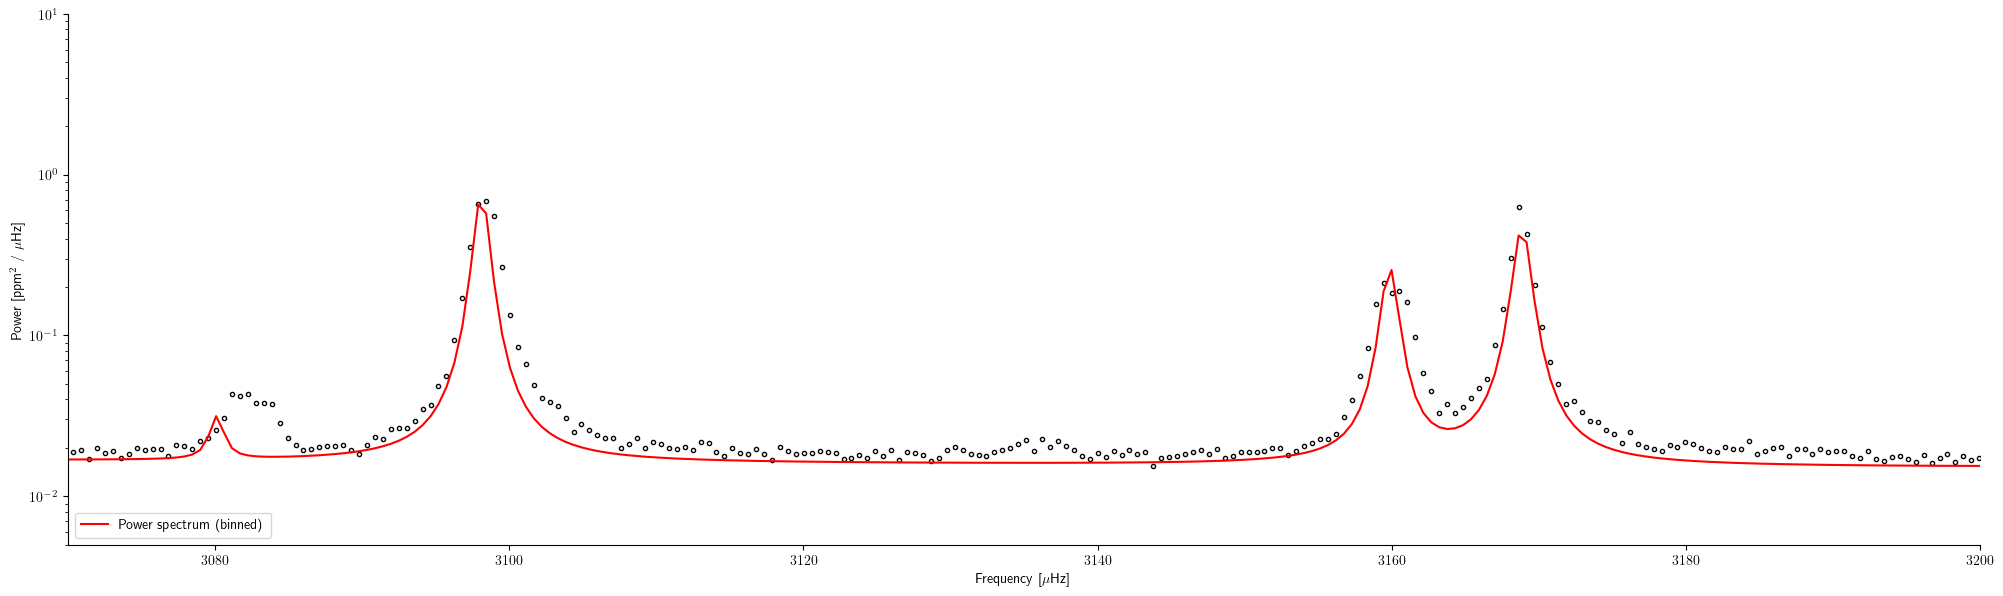

In [9]:
plt.rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(20, 6))

kernel_ps.plot(
    ax=ax,
    obs_kwargs=dict(marker='', color='r', alpha=1, lw=1.5, zorder=-10, rasterized=True)
)

cutout.plot(
    ax=ax,
    freq=kernel_freq_grid,
    # kernel=kernel,
    p_mode_inset=False,
    inset_bounds=[0.4, 0.6, 0.55, 0.35],
    obs_kwargs=dict(marker='.', color='k', zorder=-100), 
    label_obs='',
    label_kernel='gadfly',
    # kernel_kwargs=dict(color='r', alpha=1, lw=1.5, zorder=-10, rasterized=True),
    # inset_kwargs=dict(marker='.', mfc='none', color='k', zorder=10, rasterized=True, alpha=0.3),
)

ax.set(
    xlim=[3070, 3200],
    ylim=[5e-3, 1e1],
    xscale='linear'
    # yticks=10.0 ** np.arange(-2, 7)
)
ax.legend(loc='lower left')

for sp in ['right', 'top']:
    ax.spines[sp].set_visible(False)
plt.show()
# fig.savefig('plots/soho_virgo.pdf', bbox_inches='tight', dpi=250)

In [10]:
0.66 / 3

0.22

In [15]:
1 / (2*np.pi)

0.15915494309189535

In [29]:
(1 - 3090 / 3250) ** -0.25

2.12295527374695

In [15]:
(2/np.pi) ** (-1/4)

1.1195151349202477

In [ ]:
# from gadfly import scale

# freqs = np.linspace(2000, 5000) * u.uHz

# plt.plot(freqs, scale.p_mode_intensity(
#     5777*u.K, freqs, 3090*u.uHz,
#     scale._solar_delta_nu,
#     550*u.nm
# ))